In [3]:
import heist
import helpers
import torch

import gym
import random
import numpy as np
from helpers import generate_action, load_model
import imageio
import matplotlib.pyplot as plt
import typing
import math

from procgen import ProcgenGym3Env
import struct
import typing
from typing import Tuple, Dict, Callable, List, Optional
from dataclasses import dataclass
from src.policies_impala import ImpalaCNN
from procgen_tools.procgen_wrappers import VecExtractDictObs, TransposeFrame, ScaledFloatFrame

from gym3 import ToBaselinesVecEnv
import seaborn as sns
import random

%load_ext autoreload
%autoreload 2

building procgen...

/Users/bensturgeon/mambaforge/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(
/Users/bensturgeon/mambaforge/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


done


In [6]:
ordered_layer_names = {
 0: 'conv_seqs',
 1: 'conv_seqs.0',
 2: 'conv_seqs.0.conv',
 3: 'conv_seqs.0.max_pool2d',
 4: 'conv_seqs.0.res_block0',
 5: 'conv_seqs.0.res_block0.conv0',
 6: 'conv_seqs.0.res_block0.conv1',
 7: 'conv_seqs.0.res_block1',
 8: 'conv_seqs.0.res_block1.conv0',
 9: 'conv_seqs.0.res_block1.conv1',
 10: 'conv_seqs.1',
 11: 'conv_seqs.1.conv',
 12: 'conv_seqs.1.max_pool2d',
 13: 'conv_seqs.1.res_block0',
 14: 'conv_seqs.1.res_block0.conv0',
 15: 'conv_seqs.1.res_block0.conv1',
 16: 'conv_seqs.1.res_block1',
 17: 'conv_seqs.1.res_block1.conv0',
 18: 'conv_seqs.1.res_block1.conv1',
 19: 'conv_seqs.2',
 20: 'conv_seqs.2.conv',
 21: 'conv_seqs.2.max_pool2d',
 22: 'conv_seqs.2.res_block0',
 23: 'conv_seqs.2.res_block0.conv0',
 24: 'conv_seqs.2.res_block0.conv1',
 25: 'conv_seqs.2.res_block1',
 26: 'conv_seqs.2.res_block1.conv0',
 27: 'conv_seqs.2.res_block1.conv1',
 28: 'hidden_fc',
 29: 'logits_fc',
 30: 'value_fc'
}


In [7]:
def run_gem_steering_experiment(model_path, layer_number, modification_value, num_levels=1, start_level=5, episode_timeout=200, save_gif=False):
    start_level = random.randint(1, 10000)
    venv = heist.create_venv(num=1, num_levels=num_levels, start_level=start_level)
    state = heist.state_from_venv(venv, 0)
    unchanged_obs = venv.reset()

    state_values = state.state_vals

    for ents in state_values["ents"]:
        if ents["image_type"].val== 9:
            gem_x = ents["x"].val 
            gem_y = ents["y"].val 

    state.remove_gem()

    state_bytes = state.state_bytes
    if state_bytes is not None:
        venv.env.callmethod("set_state", [state_bytes])
        modified_obs = venv.reset()

    state = heist.state_from_venv(venv, 0)

    state.set_gem_position(gem_y-.5,gem_x-.5)

    state_bytes = state.state_bytes

    if state_bytes is not None:
        venv.env.callmethod("set_state", [state_bytes])


    model = helpers.load_model(model_path=model_path)
    steering_layer_unchanged = ordered_layer_names[layer_number]
    steering_layer = helpers.rename_path(steering_layer_unchanged)

    model_activations = helpers.ModelActivations(model)
    model_activations.clear_hooks()
    output1, unmodified_activations = model_activations.run_with_cache(helpers.observation_to_rgb(unchanged_obs), [ordered_layer_names[layer_number]])
    model_activations.clear_hooks()
    output2, modified_obs_activations = model_activations.run_with_cache(helpers.observation_to_rgb(modified_obs), [ordered_layer_names[layer_number]])

    steering_vector = unmodified_activations[steering_layer][0] - modified_obs_activations[steering_layer][0]

    total_reward_steering, frames_steering, observations_steering = helpers.run_episode_with_steering_and_save_as_gif(
        venv, model, steering_vector, steering_layer=ordered_layer_names[layer_number],
        modification_value=modification_value, filepath=f'episode_steering_{episode}.gif',
        save_gif=save_gif, episode_timeout=episode_timeout
    )
    helpers.plot_single_observation(observations_steering[-1])
    state = heist.state_from_venv(venv, 0)

    state_vals = state.state_vals

    lock_positions_after = heist.get_lock_statuses(state_vals)
    print(lock_positions_after)

    return total_reward_steering


model_path = "../model_final.pt"
modification_value = -2
total_episodes = 1
best_layer = None
best_score = 0
layer_number = 14


count_rewards_0 = 0
for episode in range(total_episodes):
    filepath=f'episode_steering_{episode}.gif'
    total_reward_steering = run_gem_steering_experiment(model_path, layer_number, modification_value, save_gif=False)
    print(total_reward_steering)
    if total_reward_steering == 0:
        count_rewards_0 += 1


print(f"Count rewards 0 out of total episodes: {count_rewards_0}/{total_episodes}")

    

FileNotFoundError: [Errno 2] No such file or directory: '../model_final.pt'

In [8]:
def run_episode_with_steering_and_check_target_acquisition(env, model, steering_vector, steering_layer, modification_value,filepath='../gifs/run.gif', save_gif=False, episode_timeout=400, is_procgen_env=True):
    observations = []
    observation = env.reset()

    done = False
    total_reward = 0
    frames=[]
    activations = {}
    state = heist.state_from_venv(env, 0)

    state_vals = state.state_vals

    lock_positions_before = heist.get_lock_statuses(state_vals)
    print(lock_positions_before)
    num_changes_expected = len(lock_positions_before)
    num_changes_counted = 0
    count = 0
    while not done:
        
        if save_gif:
            frames.append(env.render(mode='rgb_array'))

        observation= np.squeeze(observation)
        observation =np.transpose(observation, (1,2,0))
        converted_obs = helpers.observation_to_rgb(observation)
        action = helpers.generate_action_with_steering(model, converted_obs, steering_vector, steering_layer,modification_value, is_procgen_env)

        observation, reward, done, info = env.step(action)
    
        state = heist.state_from_venv(env, 0)
        

        total_reward += reward
        observations.append(converted_obs)
        count +=1
        if count >= episode_timeout:
            break
    
    state = heist.state_from_venv(env, 0)

    state_vals = state.state_vals

    lock_positions_after = heist.get_lock_statuses(state_vals)
    print(lock_positions_after)
    
    if save_gif:
        imageio.mimsave(filepath, frames, fps=30)
        print(f"Saved gif to {filepath}")
    
    helpers.plot_single_observation(observations[-1])
    
    
    if total_reward == 0: return True

    

    else: return False

{'x': StateValue(val=1.6237276792526245, idx=13802), 'y': StateValue(val=6.50394868850708, idx=13806), 'vx': StateValue(val=0.0, idx=13810), 'vy': StateValue(val=0.0, idx=13814), 'rx': StateValue(val=0.375, idx=13818), 'ry': StateValue(val=0.2321428656578064, idx=13822), 'type': StateValue(val=2, idx=13826), 'image_type': StateValue(val=2, idx=13830), 'image_theme': StateValue(val=1, idx=13834), 'render_z': StateValue(val=0, idx=13838), 'will_erase': StateValue(val=0, idx=13842), 'collides_with_entities': StateValue(val=0, idx=13846), 'collision_margin': StateValue(val=0.0, idx=13850), 'rotation': StateValue(val=0.0, idx=13854), 'vrot': StateValue(val=0.0, idx=13858), 'is_reflected': StateValue(val=0, idx=13862), 'fire_time': StateValue(val=-1, idx=13866), 'spawn_time': StateValue(val=-1, idx=13870), 'life_time': StateValue(val=0, idx=13874), 'expire_time': StateValue(val=-1, idx=13878), 'use_abs_coords': StateValue(val=0, idx=13882), 'friction': StateValue(val=1.0, idx=13886), 'smart_

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


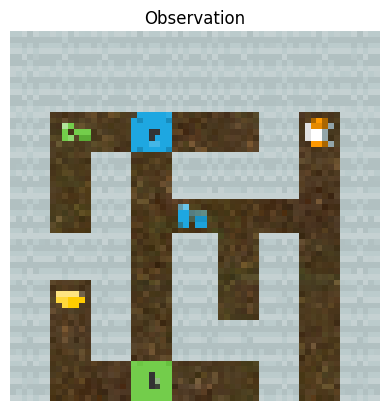

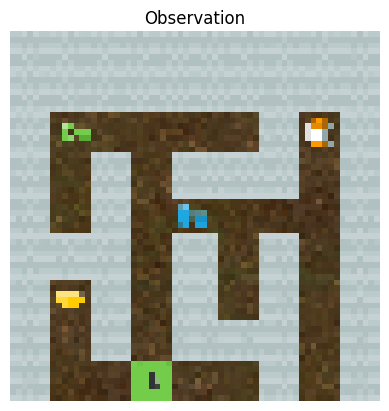

[{'x': StateValue(val=3.5, idx=13926), 'y': StateValue(val=0.5, idx=13930), 'vx': StateValue(val=0.0, idx=13934), 'vy': StateValue(val=0.0, idx=13938), 'rx': StateValue(val=0.5, idx=13942), 'ry': StateValue(val=0.5, idx=13946), 'type': StateValue(val=1, idx=13950), 'image_type': StateValue(val=1, idx=13954), 'image_theme': StateValue(val=1, idx=13958), 'render_z': StateValue(val=0, idx=13962), 'will_erase': StateValue(val=0, idx=13966), 'collides_with_entities': StateValue(val=0, idx=13970), 'collision_margin': StateValue(val=0.0, idx=13974), 'rotation': StateValue(val=0.0, idx=13978), 'vrot': StateValue(val=0.0, idx=13982), 'is_reflected': StateValue(val=0, idx=13986), 'fire_time': StateValue(val=-1, idx=13990), 'spawn_time': StateValue(val=-1, idx=13994), 'life_time': StateValue(val=0, idx=13998), 'expire_time': StateValue(val=-1, idx=14002), 'use_abs_coords': StateValue(val=0, idx=14006), 'friction': StateValue(val=1.0, idx=14010), 'smart_step': StateValue(val=0, idx=14014), 'avoids

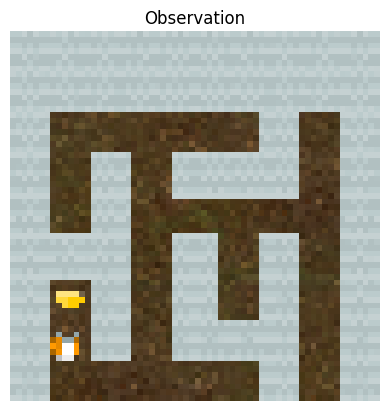

False

In [9]:
model_path = "../model_9501.0.pt"

model = helpers.load_model(model_path=model_path)
layer_number = 14
save_gif = False
episode_timeout = 200
num_levels=1


venv = heist.create_venv(num=1, num_levels=num_levels, start_level=random.randint(1, 10000))
state = heist.state_from_venv(venv, 0)
unchanged_obs = venv.reset()
state_values = state.state_vals
key_positions = heist.get_keys(state_values)

while True:
    venv = heist.create_venv(num=1, num_levels=num_levels, start_level=random.randint(1, 10000))

    state = heist.state_from_venv(venv, 0)

    unchanged_obs = venv.reset()

    state_values = state.state_vals

    key_positions = heist.get_keys(state_values)

    if key_positions.get(1) != None:
        print("Green key detected!")
        break

# delete blue key
state.delete_key(0)
state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    modified_obs_no_blue_key = venv.reset()

# Add the key back to the environment
print(f"initial: {key_positions}" )

state.set_key_position(0,key_positions[0]["x"],key_positions[0]["y"])
key_positions = heist.get_keys(state_values)


# delete the green key
state.delete_key(1)
state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    modified_obs_no_green_key = venv.reset()

# Add the key back to the environment
state.set_key_position(1,key_positions[1]["x"], key_positions[1]["y"])

state.delete_specific_locks([0])

state_bytes = state.state_bytes
venv.env.callmethod("set_state", [state_bytes])

state = heist.state_from_venv(venv, 0)
key_positions = heist.get_keys(state.state_vals)
print(f"later: {key_positions}" )


layer_names = helpers.get_model_layer_names(model)
steering_layer_unchanged = ordered_layer_names[layer_number]
steering_layer = helpers.rename_path(steering_layer_unchanged)

model_activations = helpers.ModelActivations(model)
model_activations.clear_hooks()
output1, unmodified_activations = model_activations.run_with_cache(helpers.observation_to_rgb(unchanged_obs), layer_names)
model_activations.clear_hooks()
output2, modified_obs_activations_no_blue = model_activations.run_with_cache(helpers.observation_to_rgb(modified_obs_no_blue_key), layer_names)
model_activations.clear_hooks()
output3, modified_obs_activations_no_green = model_activations.run_with_cache(helpers.observation_to_rgb(modified_obs_no_green_key), layer_names)

steering_vector_blue_key = unmodified_activations[steering_layer][0] - modified_obs_activations_no_blue[steering_layer][0]

steering_vector_green_key = unmodified_activations[steering_layer][0] - modified_obs_activations_no_green[steering_layer][0]

scaled_steering_vector_blue_key = -2 * steering_vector_blue_key
# scaled_steering_vector_green_key = 1 * steering_vector_green_key

# Combine the scaled steering vectors
# combined_steering_vector = scaled_steering_vector_blue_key + scaled_steering_vector_green_key



modification_value = 1
helpers.plot_single_observation(helpers.tensor_to_image(unchanged_obs))
helpers.plot_single_observation(helpers.tensor_to_image(venv.reset()))

run_episode_with_steering_and_check_target_acquisition(
    venv, model, steering_vector=scaled_steering_vector_blue_key, steering_layer=ordered_layer_names[layer_number],
    modification_value=modification_value, filepath=f'episode_double_steering.gif',
    save_gif=True, episode_timeout=episode_timeout
)





## Testing vector fields visualisation



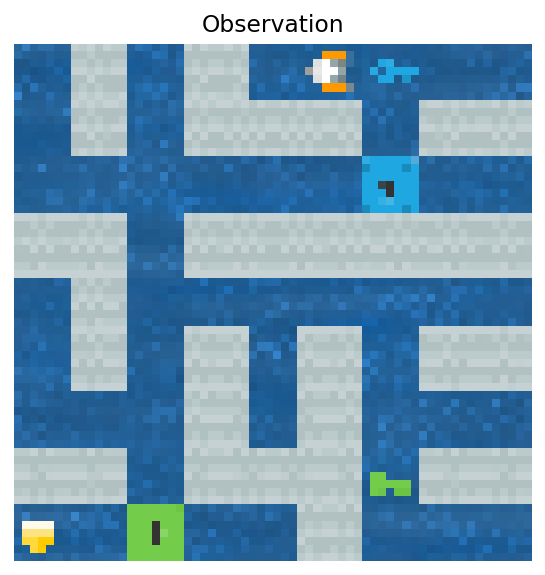

44
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 6), (0, 7), (0, 8), (1, 2), (1, 6), (2, 1), (2, 2), (2, 4), (2, 6), (2, 7), (2, 8), (3, 0), (3, 2), (3, 4), (3, 6), (4, 0), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (5, 2), (6, 0), (6, 2), (6, 3), (6, 4), (6, 5), (6, 7), (7, 0), (7, 2), (7, 6), (8, 0), (8, 2), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8)]
batched_obs.shape=torch.Size([44, 64, 64, 3])
torch.Size([44, 3, 64, 64])
Categorical(logits: torch.Size([44, 15]))
tensor([[5.9805e-02, 1.7383e-01, 5.5225e-01, 4.0571e-02, 7.6614e-03, 3.1119e-02,
         7.4854e-02, 1.1389e-02, 4.0315e-02, 1.3650e-03, 3.7884e-04, 3.5187e-04,
         8.7493e-04, 3.5380e-03, 1.7019e-03],
        [8.4365e-02, 1.6227e-01, 4.7951e-01, 3.1678e-02, 9.8945e-03, 4.0426e-02,
         1.1521e-01, 1.6496e-02, 4.9663e-02, 1.7265e-03, 5.5276e-04, 3.8141e-04,
         1.1575e-03, 4.8780e-03, 1.7869e-03],
        [5.0818e-02, 1.7576e-01, 6.8385e-01, 9.7733e-03, 5.3815e-03, 2.1730e-02,
         3.3259e-02, 3.2881e-03

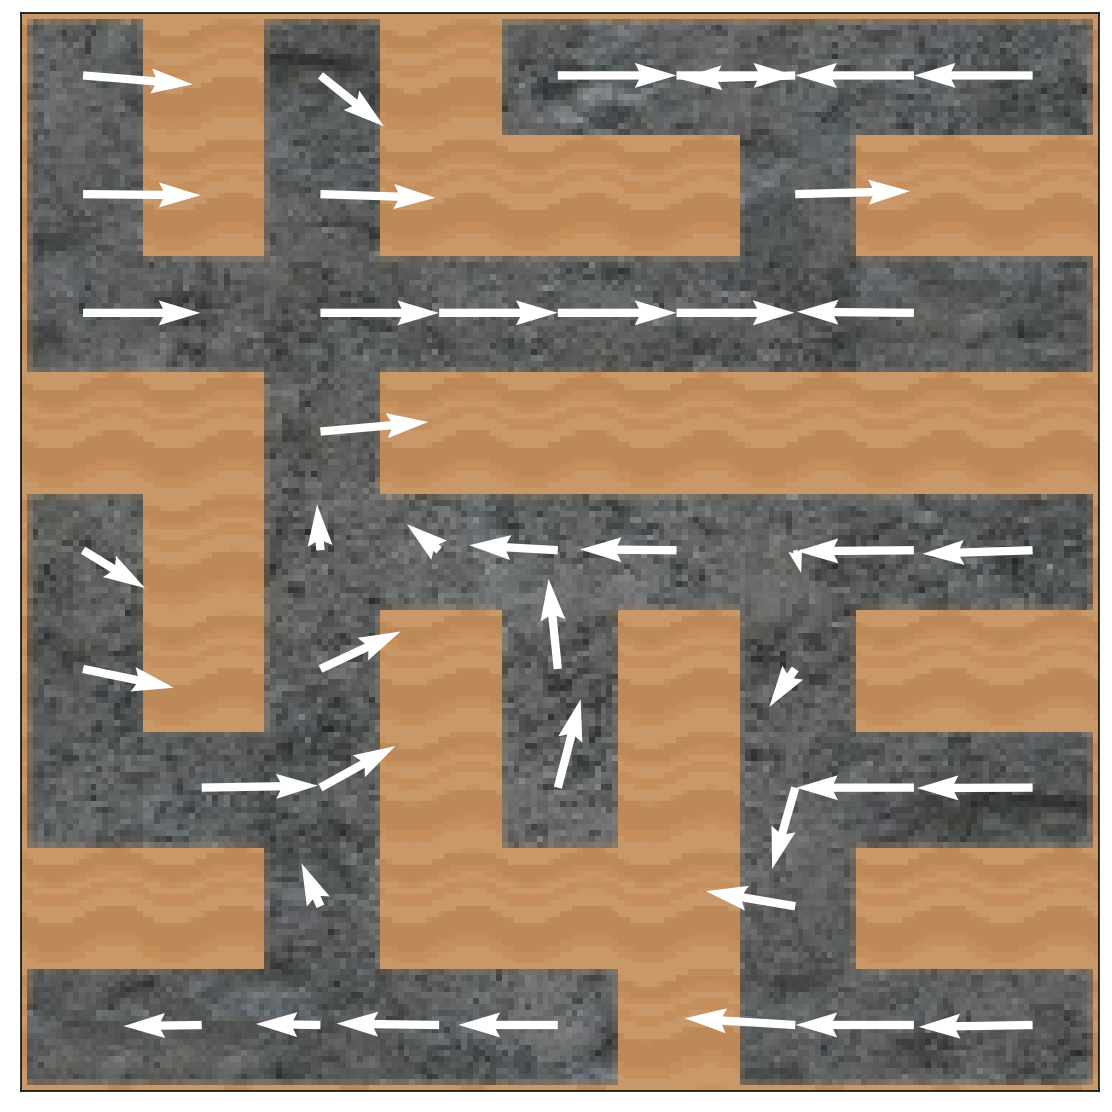

In [19]:
import matplotlib.pyplot as plt
import torch
import helpers
import heist
import procgen_tools.visualization as visualisation

# Load the model
model_path = "../../model_9501.0.pt"
model = helpers.load_model(model_path=model_path)

# Create the environment
venv = heist.create_venv(num=1, start_level=9, num_levels=1)
obs = venv.reset()
helpers.plot_single_observation(helpers.tensor_to_image(obs))
# Get the state and legal mouse positions
state = heist.state_from_venv(venv, 0)
full_grid = state.full_grid(with_mouse=False)
legal_mouse_positions = heist.get_legal_mouse_positions(full_grid, state.state_vals["ents"])
print(len(legal_mouse_positions))

# Generate the vector field
venv_all, (legal_mouse_positions, full_grid) = heist.venv_with_all_mouse_positions(venv)
obs_all = venv_all.reset()
obs_all = obs_all.transpose(0,2,3,1) # Permute dimensions to match the expected input shape
converted_obs_all = []
for obs in obs_all:
    mod_obs = helpers.observation_to_rgb(obs)
    converted_obs_all.append(torch.tensor(mod_obs, dtype=torch.float32).unsqueeze(0)) # Add an extra dimension to match the expected input shape

converted_obs_all = torch.cat(converted_obs_all, dim=0)
c, v = model(converted_obs_all)

vf = visualisation.vector_field_tup(c,venv_all, legal_mouse_positions, full_grid, model)

# Plot the vector field
fig, ax = plt.subplots(figsize=(10, 10))
visualisation.plot_vf(vf, ax=ax, human_render=True, render_padding=False)


plt.show()

# helpers.plot_single_observation(obs_all[0].transpose(2,1,0))

# helpers.plot_single_observation(converted_obs_all[0])

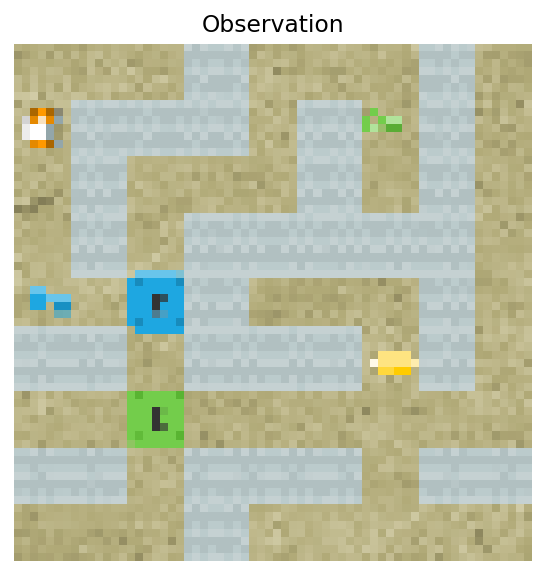

conv_seqs.1.res_block0.conv0


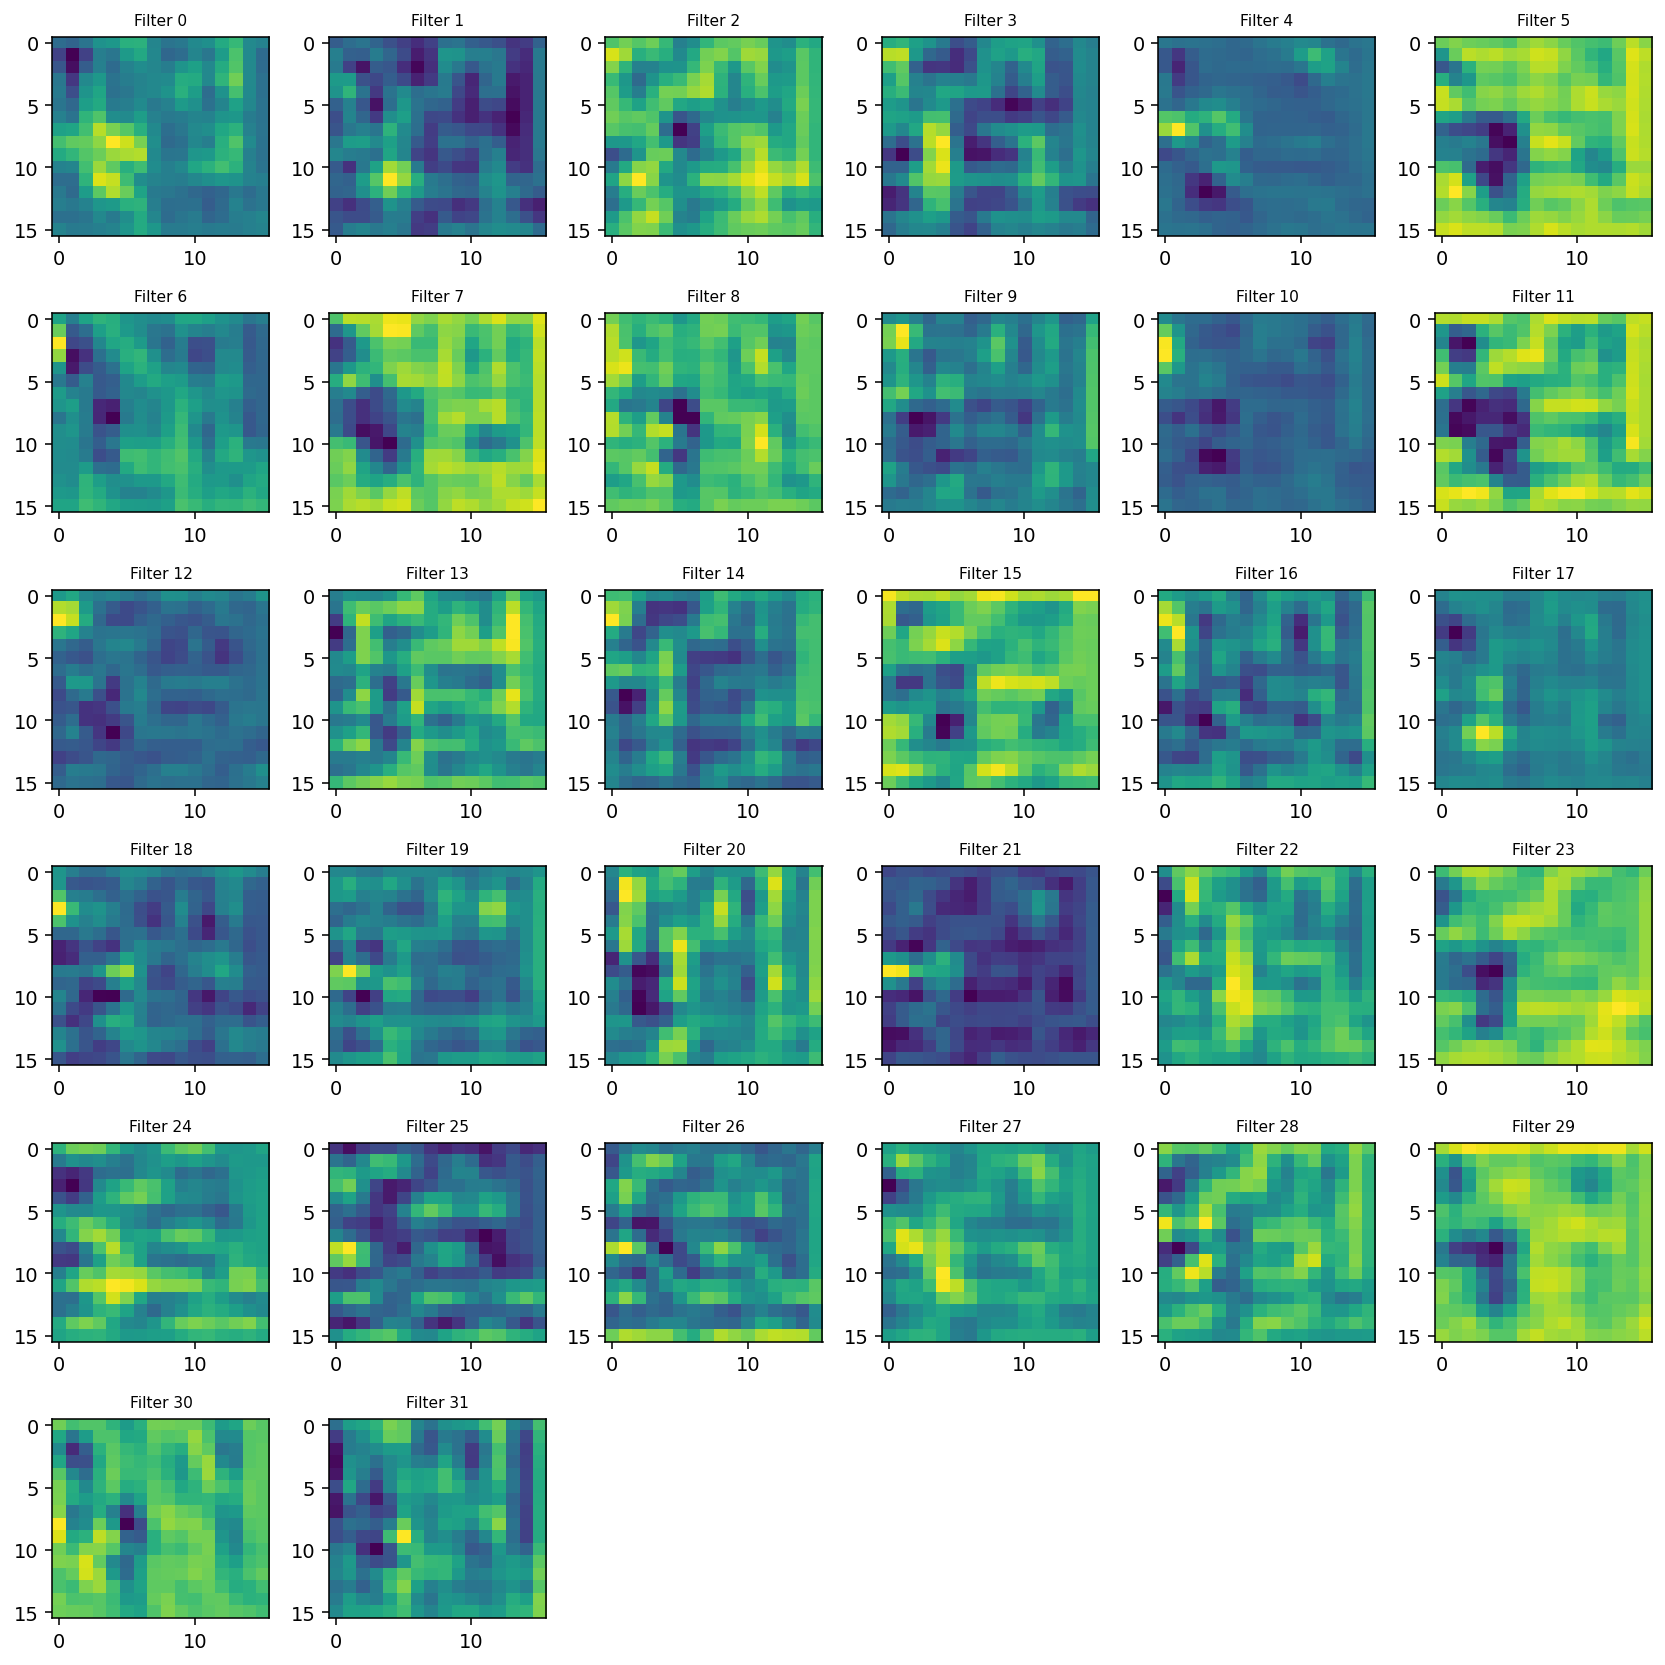

In [35]:

model_path = "../../model_9501.0.pt"
model = helpers.load_model(model_path=model_path)

# Create the environment
venv = heist.create_venv(num=1, start_level=5, num_levels=1)
obs = venv.reset()
helpers.plot_single_observation(helpers.tensor_to_image(obs))


layer_names = helpers.get_model_layer_names(model)

model_activations = helpers.ModelActivations(model)
model_activations.clear_hooks()
output1, unmodified_activations = model_activations.run_with_cache(helpers.observation_to_rgb(obs), layer_names)

layer_num = 14

print(layer_names[layer_num])

default_layer = helpers.rename_path(layer_names[layer_num])

helpers.plot_layer_activations_dynamic_grid(unmodified_activations,default_layer)


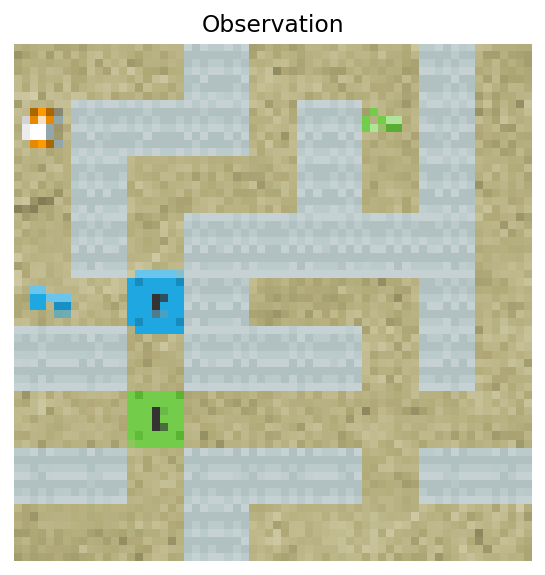

In [69]:
model_path = "../model_9501.0.pt"

model = helpers.load_model(model_path=model_path)
episode_timeout = 200
num_levels=1

venv = heist.create_venv(num=1, num_levels=num_levels, start_level=5)
state = heist.state_from_venv(venv, 0)

# Remove the gem
state.remove_gem()
state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    modified_obs_no_gem = venv.reset()

helpers.plot_single_observation(helpers.tensor_to_image(modified_obs_no_gem))

_, frames, observations = helpers.run_episode_and_save_as_gif(
    venv, model, filepath=f'episode_0.gif',
    save_gif=True, episode_timeout=episode_timeout
)
# imageio.mimsave('episode_gif.gif' , frames, fps=30) 

In [31]:
def run_episode_and_check_key_acquisition(model, episode_timeout=400):
    while True:
        env = heist.create_venv(num=1, num_levels=1, start_level=random.randint(1, 10000))
        state = heist.state_from_venv(env, 0)
        state_vals = state.state_vals
        key_positions = heist.get_keys(state_vals)

        # Only run the episode if a blue key is present
        if key_positions.get(0) is not None:
            break

    observations = []
    observation = env.reset()

    done = False
    prev_key_positions = key_positions
    first_observation = observation
    observation= np.squeeze(observation)
    observation =np.transpose(observation, (1,2,0))
    converted_obs = helpers.observation_to_rgb(observation)

    action = helpers.generate_action(model, converted_obs, is_procgen_env=True)

    while not done:

        observation, reward, done, info = env.step(action)
        observation= np.squeeze(observation)
        observation =np.transpose(observation, (1,2,0))
        converted_obs = helpers.observation_to_rgb(observation)

        action = helpers.generate_action(model, converted_obs, is_procgen_env=True)

    
        state = heist.state_from_venv(env, 0)


        state = heist.state_from_venv(env, 0)
        state_vals = state.state_vals
        key_positions = heist.get_keys(state_vals)


        # Check if the number of entities has changed or if the blue key position has changed
        if key_positions != prev_key_positions:
            return first_observation, converted_obs


    return None
model_path = "../model_9501.0.pt"

model = helpers.load_model(model_path=model_path)
first_obs, new_obs = run_episode_and_check_key_acquisition(model)


{'x': StateValue(val=5.4529032707214355, idx=13955), 'y': StateValue(val=3.589113712310791, idx=13959), 'vx': StateValue(val=0.0, idx=13963), 'vy': StateValue(val=0.0, idx=13967), 'rx': StateValue(val=0.375, idx=13971), 'ry': StateValue(val=0.2321428656578064, idx=13975), 'type': StateValue(val=2, idx=13979), 'image_type': StateValue(val=2, idx=13983), 'image_theme': StateValue(val=0, idx=13987), 'render_z': StateValue(val=0, idx=13991), 'will_erase': StateValue(val=0, idx=13995), 'collides_with_entities': StateValue(val=0, idx=13999), 'collision_margin': StateValue(val=0.0, idx=14003), 'rotation': StateValue(val=0.0, idx=14007), 'vrot': StateValue(val=0.0, idx=14011), 'is_reflected': StateValue(val=0, idx=14015), 'fire_time': StateValue(val=-1, idx=14019), 'spawn_time': StateValue(val=-1, idx=14023), 'life_time': StateValue(val=0, idx=14027), 'expire_time': StateValue(val=-1, idx=14031), 'use_abs_coords': StateValue(val=0, idx=14035), 'friction': StateValue(val=1.0, idx=14039), 'smart

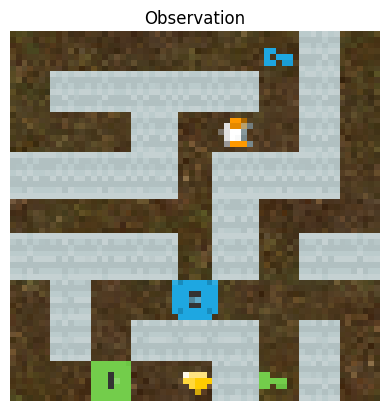

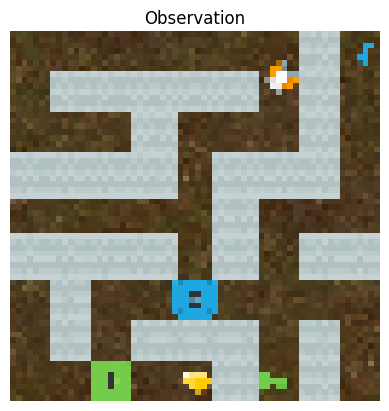

In [30]:
helpers.plot_single_observation(helpers.tensor_to_image(first_obs))
helpers.plot_single_observation(helpers.tensor_to_image(new_obs).transpose(2,0,1))
